In [2]:
# splicing categories are pairwise (do they need a reference?)
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from venn import venn

from data_loading import load_annotated_6k_collection, load_annotated_gencode_tfs

In [ ]:
# add activation domains
# add uniprot isoform IDs

In [3]:
tfs = load_annotated_6k_collection()

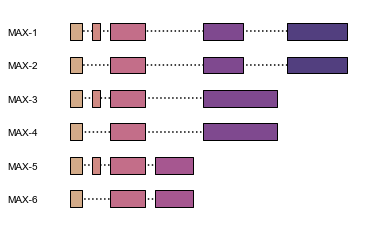

In [4]:
tfs['MAX'].exon_diagram()

In [93]:
tfs['ATF2']['ATF2-2'].is_MANE_select_transcript

False

In [111]:
genes = tfs

path_APPRIS = '../data/external/APPRIS-annotations_human_GRCh38.p13_ensembl104.tsv'
appris = pd.read_csv(path_APPRIS, sep='\t')
if appris['Transcript stable ID'].duplicated().any():
    raise UserWarning('Unexpected duplicate ensembl transcript IDs in {}'.format(path_APPRIS))
appris = appris.set_index('Transcript stable ID')['APPRIS annotation'].to_dict()

def _consolidate_appris_annotations(annotations):
    return sorted(list(annotations), key=lambda x: int(x[-1]) - 99 * x.startswith('principle'))[0]

for tf in genes.values():
    for iso in tf.orfs:
        if iso.is_novel_isoform():
            continue
        annotations = {appris[tid] for tid in iso.ensembl_transcript_ids if tid in appris}
        if len(annotations) > 0:
            iso.APPRIS_annotation = _consolidate_appris_annotations(annotations)

In [120]:
tfs['ATF2']['ATF2-1'].APPRIS_annotation

'alternative1'

In [118]:
_consolidate_appris_annotations({'alternative1', 'principle1'})

'principle1'

In [115]:
tfs['RBPJ']['RBPJ-1'].APPRIS_annotation

'principal2'

In [23]:
from data_loading import load_valid_isoform_clones
clones = load_valid_isoform_clones()
novel = set(clones.loc[clones['is_novel_isoform'], 'clone_acc'].values)
for tf in tfs.values():
    for iso in tf.orfs:
        iso.is_novel = iso.clone_acc in novel

In [24]:
print(len([iso for tf in tfs.values() for iso in tf.orfs]), 'total isoforms')
print(len([iso for tf in tfs.values() for iso in tf.orfs
           if iso.ensembl_protein_ids is not None]), 'isoforms matched to ensembl')
print(len([iso for tf in tfs.values() for iso in tf.orfs
           if not iso.is_novel]), 'according to previous mapping')
print(len([iso for tf in tfs.values() for iso in tf.orfs
           if iso.ensembl_protein_ids is not None
           and iso.alignment_clone_to_ensembl_score[0] == 1]), 'perfect matches')
print(len([iso for tf in tfs.values() for iso in tf.orfs
           if iso.ensembl_protein_ids is not None
           and iso.alignment_clone_to_ensembl_score[1] == 1
           and iso.alignment_clone_to_ensembl_score[2] == 0]), 'one mismatched AA')

756 total isoforms
593 isoforms matched to ensembl
567 according to previous mapping
456 perfect matches
89 one mismatched AA


In [47]:
print(len([iso for tf in tfs.values() for iso in tf.orfs
           if iso.ensembl_protein_ids is not None
           and not iso.is_novel
           and iso.alignment_clone_to_ensembl_score[2] > 0]), 'with gaps in previous mapping')

0 with gaps in previous mapping


In [53]:

print([iso for tf in tfs.values() for iso in tf.orfs
           if iso.ensembl_protein_ids is not None
           and iso.is_novel
           and iso.alignment_clone_to_ensembl_score[1] == 1
           and iso.alignment_clone_to_ensembl_score[2] == 0], 'inconsitent case...')

[Clone acc: ZBTB44|6/9|12H02
Isoform: ZBTB44-203 / ENSP00000408079 / ENST00000445008
length: 467 aa] consitent previous mapping


In [37]:
# 567 non-novel iso from previous data
from collections import Counter
pd.DataFrame([(int(k[0]), int(k[1]), v) for k, v in Counter([iso.alignment_clone_to_ensembl_score[1:] for tf in tfs.values() for iso in tf.orfs
           if iso.ensembl_protein_ids is not None]).items()],
            columns=['Number of mismatches', 
            'Number of gaps',
             'Number of clones']).sort_values([ 
            'Number of gaps',
             'Number of mismatches'])

,Number of mismatches,Number of gaps,Number of clones
0,0,0,456
1,1,0,89
4,2,0,21
14,3,0,2
6,0,1,8
3,1,1,4
8,3,1,2
2,4,1,1
9,0,2,1
10,1,5,2


In [38]:
[iso for tf in tfs.values() for iso in tf.orfs
           if iso.ensembl_protein_ids is not None
           and iso.alignment_clone_to_ensembl_score[1] == 0
           and iso.alignment_clone_to_ensembl_score[2] == 1]

[Clone acc: KLF7|4/8|10E10
 Isoform: KLF7-203 / ENSP00000387510 / ENST00000421199
 length: 270 aa,
 Clone acc: TFCP2|2/3|03H07
 Isoform: TFCP2-204 / ENSP00000447991 / ENST00000548115
 length: 451 aa,
 Clone acc: TCF12|3/3|07B07
 Isoform: TCF12-203 / ENSP00000342459 / ENST00000343827
 length: 511 aa,
 Clone acc: RORA|2/2|05H06
 Isoform: RORA-204 / ENSP00000402971 / ENST00000449337
 length: 467 aa,
 Clone acc: ZFP1|1/4|04C02
 Isoform: ZFP1-209|ZFP1-202 / ENSP00000457044|ENSP00000377080 / ENST00000570010|ENST00000393430
 length: 406 aa,
 Clone acc: ZNF419|3/4|02D10
 Isoform: ZNF419-204 / ENSP00000392129 / ENST00000415379
 length: 465 aa,
 Clone acc: ZNF430|2/4|01E09
 Isoform: ZNF430-206 / ENSP00000471313 / ENST00000599548
 length: 112 aa,
 Clone acc: ZIC3|3/3|09C04
 Isoform: ZIC3-202 / ENSP00000359638 / ENST00000370606
 length: 456 aa]

In [54]:
tfs['TFCP2'].exon_diagram()

In [55]:
tfs['TFCP2'].orfs

[Clone acc: TFCP2|1/3|03E08
 Isoform: TFCP2-201 / ENSP00000257915 / ENST00000257915
 length: 502 aa,
 Clone acc: TFCP2|2/3|03H07
 Isoform: TFCP2-204 / ENSP00000447991 / ENST00000548115
 length: 451 aa,
 Clone acc: TFCP2|3/3|03F10
 Isoform: TFCP2-3
 length: 368 aa]

In [44]:
# something going wrong with RORA

tfs['RORA']['RORA-1']

Clone acc: RORA|1/2|05G07
Isoform: RORA-204 / ENSP00000402971 / ENST00000449337
length: 468 aa

In [ ]:

[iso.alignment_clone_to_ensembl_score[1:] for tf in tfs.values() for iso in tf.orfs
           if iso.ensembl_protein_ids is not None]

In [ ]:
# number of clones with exact match
# number of clones with 1, 2, 3, 4, 5 different AA
# number of clones with different insertions / deletions

In [251]:
tfs['ZNF747'].orfs

[Clone acc: ZNF747|1/4|03E01
 Isoform: ZNF747-203 / ENSP00000457274 / ENST00000568028
 length: 330 aa,
 Clone acc: ZNF747|2/4|03B01
 Isoform: ZNF747-201 / ENSP00000252799 / ENST00000252799
 length: 191 aa,
 Clone acc: ZNF747|3/4|02E12
 Isoform: ZNF747-3
 length: 190 aa]

In [264]:
seq_a = tfs['ZNF747']['ZNF747-2'].aa_seq
seq_b = ensembl_aa_seq['ZNF747-202']
aligner = Align.PairwiseAligner()
aligner.mode = 'global'
aligner.match_score = 1
aligner.mismatch_score = -1
aligner.gap_score = -1
alignment = aligner.align(seq_a, seq_b)[0].__str__()
print(alignment)

MTDPSLGLTVPMAPPLAPLPPRDPNGAGSEWRKPGAVSFADVAVYFSREEWGCLRPAQRALYRDVMRETYGHLGALGESPTCLPGPCASTGPAAPLGAACGVGGPGAGQAASSQRGVCVLLPQESEAASRRSSPGWRRRPNCGIRLPRIRRWRSVRQKRTQQIPETRKRKDKGKGREPWRSPTLWPPGLLG
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||-|||||||||||||||||||||||||||||
MTDPSLGLTVPMAPPLAPLPPRDPNGAGSEWRKPGAVSFADVAVYFSREEWGCLRPAQRALYRDVMRETYGHLGALGESPTCLPGPCASTGPAAPLGAACGVGGPGAGQAASSQRGVCVLLPQESEAASRRSSPGWRRRPNCGIRLPRIRRWRSVRQKRTQ-IPETRKRKDKGKGREPWRSPTLWPPGLLG



In [263]:
_seq_identity(ensembl_aa_seq['ZNF747-202'], tfs['ZNF747']['ZNF747-2'].aa_seq)

0.9947643979057592

In [266]:
print(len([iso for tf in tfs.values() for iso in tf.orfs if iso.ensembl_protein_ids is not None]),
      len([iso for tf in tfs.values() for iso in tf.orfs if iso.ensembl_protein_ids is None]))
print(clones['is_novel_isoform'].value_counts())

593 163
False    567
True     191
Name: is_novel_isoform, dtype: int64


In [267]:
novel = set(clones.loc[clones['is_novel_isoform'], 'clone_acc'].values)
print('isoforms im saying are novel and previously were matched')
[iso for tf in tfs.values() for iso in tf.orfs if iso.ensembl_protein_ids is None and iso.clone_acc not in novel]

isoforms im saying are novel and previously were matched


[Clone acc: ZNF747|3/4|02E12
 Isoform: ZNF747-3
 length: 190 aa]

In [268]:
[iso for tf in tfs.values() for iso in tf.orfs if iso.ensembl_protein_ids is not None and iso.clone_acc in novel]

[Clone acc: PRDM16|1/2|08F02
 Isoform: PRDM16-201 / ENSP00000270722 / ENST00000270722
 length: 1275 aa,
 Clone acc: PRDM16|2/2|08G01
 Isoform: PRDM16-206 / ENSP00000426975 / ENST00000511072
 length: 1177 aa,
 Clone acc: ESRRG|1/2|09B10
 Isoform: ESRRG-205 / ENSP00000355904 / ENST00000366937
 length: 463 aa,
 Clone acc: ESRRG|2/2|09C10
 Isoform: ESRRG-224|ESRRG-208|ESRRG-204|ESRRG-207|ESRRG-202|ESRRG-203|ESRRG-206|ESRRG-201|ESRRG-221|ESRRG-219|ESRRG-222 / ENSP00000481528|ENSP00000375761|ENSP00000355225|ENSP00000355907|ENSP00000353108|ENSP00000354584|ENSP00000355905|ENSP00000352077|ENSP00000419594|ENSP00000419155|ENSP00000417374 / ENST00000616180|ENST00000391890|ENST00000361525|ENST00000366940|ENST00000360012|ENST00000361395|ENST00000366938|ENST00000359162|ENST00000493603|ENST00000487276|ENST00000493748
 length: 442 aa,
 Clone acc: ZNF692|1/3|06D07
 Isoform: ZNF692-201 / ENSP00000305483 / ENST00000306601
 length: 518 aa,
 Clone acc: IKZF2|1/4|02B07
 Isoform: IKZF2-201 / ENSP00000342876 /

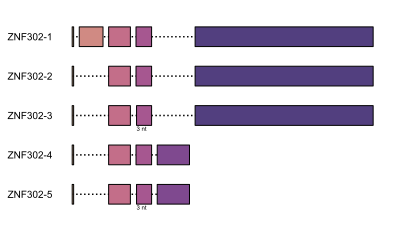

In [271]:
tfs['ZNF302'].exon_diagram()

In [278]:
# check alignment of NT sequence...
print(aligner.align(tfs['ZNF302']['ZNF302-1'].aa_seq, ensembl_aa_seq['ZNF302-202'])[0].__str__())

MSQRQYPECYLAPNGCLVSNCGVNKMSNEELVGQNHGMEGEACTGGDVTFSDVAIDFSHEEWACLDSAQRDLYKDVMVQNYENLVSVAGLSVTKPYVIMLLEDGKEPWMMEKKLSKDWESRWENKELSTKKDICDEDSPQPVTMEKVVKQSYEFSNSNKNLEYTECDTFRSTFHSKSTLSEPQNNSAEGNSHKYDILKKNLSKKSVIKSERINGGKKLLNSNKSGAAFNQSKSLTLPQTCNREKIYTCSECGKAFGKQSILSRHWRIHTGEKPYECRECGKTFSHGSSLTRHQISHSGEKPYKCIECGKAFSHGSSLTNHQSTHTGEKPYECMNCGKSFSRVSLLIQHLRIHTQEKRYECRICGKAFIHSSSLIHHQKSHTGEKPYECRECGKAFCCSSHLTQHQRIHSMKKKYECNKCLKVFSSFSFLVQHQSIHTEEKPFEV
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||-|||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
MSQRQYPECYLAPNGCLVSNCGVNKMSNEELVGQNHGMEGEACTGGDVTFSDVAIDFSHEEWACLDSAQRDLYKDVMVQNYENLVSV-GLSVTKPYVIMLLEDGKEPWMM

In [273]:
tfs['ZNF302']

Gene: ZNF302
Isoforms: ['ZNF302-1', 'ZNF302-2', 'ZNF302-3', 'ZNF302-4', 'ZNF302-5']

In [269]:
tfs['ZNF302'].orfs

[Clone acc: ZNF302|1/5|06F09
 Isoform: ZNF302-202 / ENSP00000396379 / ENST00000446502
 length: 444 aa,
 Clone acc: ZNF302|2/5|06B07
 Isoform: ZNF302-214 / ENSP00000481754 / ENST00000613363
 length: 400 aa,
 Clone acc: ZNF302|3/5|06H06
 Isoform: ZNF302-203|ZNF302-206|ZNF302-201 / ENSP00000391067|ENSP00000421028|ENSP00000405219 / ENST00000457781|ENST00000505242|ENST00000423823
 length: 399 aa,
 Clone acc: ZNF302|4/5|06G08
 Isoform: ZNF302-208|ZNF302-209 / ENSP00000424292|ENSP00000421201 / ENST00000506901|ENST00000507959
 length: 132 aa,
 Clone acc: ZNF302|5/5|06H08
 Isoform: ZNF302-207 / ENSP00000423235 / ENST00000505365
 length: 131 aa]

In [94]:
# TEST
from data_loading import load_valid_isoform_clones
clones = load_valid_isoform_clones()
clones['is_novel_isoform'].value_counts()  # CHECK novel isoform against current results

False    567
True     191
Name: is_novel_isoform, dtype: int64

In [89]:
clones.loc[clones['clone_acc'] == 'ATF2|1/6|12H04', 'aa_seq'].values

array(['MKFKLHVNSARQYKDLWNMSDDKPFLCTAPGCGQRFTNEDHLAVHKHKHEMTLKFGPARNDSVIVADQTPTPTRFLKNCEEVGLFNELASPFENEFKKASEDDIKKMPLDLSPLATPIIRSKIEEPSVVETTHQDSPLPHPESTTSDEKEVPLAQTAQPTSAIVRPASLQVPNVLLTSSDSSVIIQQAVPSPTSSTVITQAPSSNRPIVPVPGPFPLLLHLPNGQTMPVAIPASITSSNVHVPAAVPLVRPVTMVPSVPGIPGPSSPQPVQSEAKMRLKAALTQQHPPVTNGDTVKGHGSGLVRTQSEESRPQSLQQPATSTTETPASPAHTTPQTQSTSGRRRRAANEDPDEKRRKFLERNRAAASRCRQKRKVWVQSLEKKAEDLSSLNGQLQSEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSEDISVPSSPHTEAIQHSSVSTSNGVSSTSKAEAVATSVLTQMADQSTEPALSQIVMAPSSQSQPSGS'],
      dtype=object)

In [86]:
path_gencode_aa_seq = '../data/external/gencode.v30.pc_translations.fa'
from collections import defaultdict

from Bio import SeqIO

ensembl_proteins = defaultdict(list)
for record in SeqIO.parse(path_gencode_aa_seq, 'fasta'):
    ids = record.id.split('|')
    ensembl_proteins[str(record.seq)].append((ids[0].split('.')[0], ids[1].split('.')[0], ids[5]))


for tf in tfs.values():
    for isoform in tf.orfs:
        if isoform.aa_seq in ensembl_proteins:
            isoform.ensembl_protein_ids = [ids[0] for ids in ensembl_proteins[isoform.aa_seq]]
            isoform.ensembl_transcript_ids = [ids[1] for ids in ensembl_proteins[isoform.aa_seq]]
            isoform.ensembl_transcript_names = [ids[2] for ids in ensembl_proteins[isoform.aa_seq]]

tfs['ATF2']['ATF2-1'].ensembl_protein_ids

['ENSP00000264110', 'ENSP00000376327']

In [62]:
tfs = load_annotated_6k_collection()
tfs_gc = load_annotated_gencode_tfs()

100%|██████████| 2748/2748 [01:36<00:00, 28.57it/s]


In [34]:
s = """ATAGGGCCGCCATCGCCGGGCGACGACGAGGAGGAGGCGGCCGCCGCAGCCGGGGCCCCCGCCGCCGCCGGAGCGACAGGTGATTTGGCTTCTGCACAGTTAGGAGGAGCACCAAACCGATGGGAGGTTTTGTCAGCCACACCTACAACTATAAAAGATGAAGCTGGTAATCTAGTCCAGATTCCAAGTGCTGCTACTTCAAGTGGGCAGTATGTTCTTCCCCTTCAGAATTTGCAGAATCAACAAATATTTTCCGTTGCACCAGGATCAGATTCATCAAATGGTACAGTGTCCAGTGTTCAATATCAAGTGATACCACAGATCCAGTCAGCAGATGGTCAGCAGGTTCAAATTGGTTTCACAGGCTCTTCAGATAATGGGGGTATAAATCAAGAAAGCAGTCAAATTCAGATCATTCCTGGCTCTAATCAAACCTTACTTGCCTCTGGAACACCTTCTGCTAACATCCAGAATCTCATACCACAGACTGGTCAAGTCCAGGTTCAGGGAGTTGCAATTGGTGGTTCATCTTTTCCTGGTCAAACCCAAGTAGTTGCTAATGTGCCTCTTGGTCTGCCAGGAAATATTACGTTTGTACCAATCAATAGTGTCGATCTAGATTCTTTGGGACTCTCGGGCAGTTCTCAGACAATGACTGCAGGCATTAATGCCGACGGACATTTGATAAACACAGGACAAGCTATGGATAGTTCAGACAATTCAGAAAGGACTGGTGAGCGGGTTTCTCCTGATATTAATGAAACTAATACTGATACAGATTTATTTGTGCCAACATCCTCTTCATCACAGTTGCCTGTTACGATAGATAGTACAGGTATATTACAACAAAACACAAATAGCTTGACTACATCTAGTGGGCAGGTTCATTCTTCAGATCTTCAGGGAAATTATATCCAGTCGCCTGTTTCTGAAGAGACACAGGCACAGAATATTCAGGTTTCTACAGCACAGCCTGTTGTACAGCATCTACAACTTCAAGAGTCTCAGCAGCCAACCAGTCAAGCCCAAATTGTGCAAGGTATTACACCACAGACAATCCATGGTGTGCAAGCCAGTGGTCAAAATATATCACAACAGGCTTTGCAAAATCTTCAGTTGCAGCTGAATCCTGGAACCTTTTTAATTCAGGCACAGACAGTGACCCCTTCTGGACAGGTAACTTGGCAAACGTTTCAAGTACAAGGGGTCCAGAACTTGCAGAATTTGCAAATACAGAATACTGCTGCCCAACAAATAACTTTGACGCCTGTTCAAACCCTCACACTTGGTCAAGTTGCGGCAGGTGGAGCCTTCACTTCAACTCCAGTTAGTCTAAGCACTGGTCAGTTGCCAAATCTACAAACAGTTACAGTGAACTCTATAGATTCTGCTGGTATACAGCTACATCCAGGAGAGAATGCTGACAGTCCTGCAGATATTAGGATCAAGGAAGAAGAACCTGATCCTGAAGAGTGGCAGCTCAGTGGTGATTCTACCTTGAATACCAATGACCTAACACACTTAAGAGTACAGGTGGTAGATGAAGAAGGGGACCAACAACATCAAGAAGGAAAAAGACTTCGGAGGGTAGCTTGCACCTGTCCCAACTGTAAAGAAGGTGGTGGAAGAGGTACCAATCTTGGGAAAAAGAAGCAACACATTTGTCATATACCAGGATGTGGTAAAGTCTATGGGAAGACCTCACATCTGAGAGCTCATCTGCGTTGGCATTCTGGAGAACGCCCTTTTGTTTGTAACTGGATGTACTGTGGTAAAAGATTTACTCGAAGTGATGAATTACAGAGGCACAGAAGAACACATACAGGTGAGAAGAAATTTGTTTGTCCAGAATGTTCAAAACGCTTTATGAGAAGTGACCACCTTGCCAAACATATTAAAACACACCAGAATAAAAAAGGTATTCACTCTAGCAGTACAGTGCTGGCATCTGTGGAAGCTGCGCGAGATGATACTTTGATTACTGCAGGAGGAACAACGCTTATCCTTGCAAATATTCAACAAGGTTCTGTTTCAGGGATAGGAACTGTTAATACTTCCGCCACCAGCAATCAAGATATCCTTACCAACACTGAAATACCTTTACAGCTTGTCACAGTTTCTGGAAATGAGACAATGGAG"""
from Bio.Seq import Seq
str(Seq(s).translate(cds=True, table=2))

TranslationError: Final codon 'GAG' is not a stop codon

In [31]:
help(Seq.translate, cds=True)

TypeError: __call__() got an unexpected keyword argument 'cds'

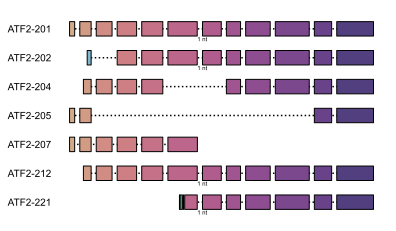

In [11]:
tfs_gc['ATF2'].exon_diagram()

In [17]:
print((tfs_gc['ATF2'].exons[0].start, tfs_gc['ATF2'].exons[0].end))
print((tfs_gc['ATF2'].exons[-1].start, tfs_gc['ATF2'].exons[-1].end))

(175136411, 175136443)
(175074611, 175074835)


In [95]:
print(len(tfs['ZNF343']['ZNF343-4'].clone_nt_seq))
print(len(tfs['ZNF343']['ZNF343-4'].nt_seq))
print(tfs['ZNF343']['ZNF343-4'].exons[-1].start, tfs['ZNF343']['ZNF343-4'].exons[-1].end)
tfs['ZNF343'].exon_diagram()

349
348
2492034 2492078


<Figure size 432x288 with 1 Axes>

In [40]:
# when is the sum of exon length equal to the aa sequence?

exon_eq_coding = [orf for tf in tfs.values() for orf in tf.orfs if sum(len(e) for e in orf.exons) == len(orf.nt_seq)]
exon_eq_clone = [orf for tf in tfs.values() for orf in tf.orfs 
                  if (sum(len(e) for e in orf.exons) == len(orf.clone_nt_seq)) and (len(orf.clone_nt_seq) != len(orf.nt_seq))]
print(len(exon_eq_coding), len(exon_eq_clone))


704 52


In [44]:
# investigate the ones where the exon includes stop etc etc.

ORF: GMEB1-2

In [55]:
tfs['GMEB1']['GMEB1-1'].ensembl_transcript_id

True

In [52]:
# 28714073        28714770n
# 28714739        28714770
tfs['GMEB1'].exon_diagram()

<Figure size 432x288 with 1 Axes>

In [70]:
#sorted([orf for tf in tfs.values() for orf in tf.orfs],
#        key=lambda x: sum(len(e) for e in x.exons) - len(x.nt_seq))[-1]


print(len(tfs['SMAD4']['SMAD4-1'].clone_nt_seq),
      len(tfs['SMAD4']['SMAD4-1'].nt_seq))
print(tfs['SMAD4']['SMAD4-1'].exons)
tfs['SMAD4'].exon_diagram()

1771 1458
[Exon of SMAD4|1/2|01A02 249 nt
, Exon of SMAD4|1/2|01A02 175 nt
, Exon of SMAD4|1/2|01A02 30 nt
, Exon of SMAD4|1/2|01A02 213 nt
, Exon of SMAD4|1/2|01A02 120 nt
, Exon of SMAD4|1/2|01A02 117 nt
, Exon of SMAD4|1/2|01A02 51 nt
, Exon of SMAD4|1/2|01A02 184 nt
, Exon of SMAD4|1/2|01A02 169 nt
, Exon of SMAD4|1/2|01A02 139 nt
, Exon of SMAD4|1/2|01A02 113 nt
, Exon of SMAD4|1/2|01A02 211 nt
]


<Figure size 432x288 with 1 Axes>

In [84]:
tfs['SMAD4'].exon_diagram()

<Figure size 432x288 with 1 Axes>

In [82]:
orf = tfs['SMAD4']['SMAD4-1']
print(
orf.start,
orf.exons[0].start,
orf.end,
orf.exons[-1].end
)

51047046 51047046 51078466 51077317


In [73]:
tfs['SMAD4']['SMAD4-1'].strand

'+'

In [57]:
# GMEB1-2
tfs['GMEB1']['GMEB1-2'].exons

[Exon of GMEB1|2/2|02A08 128 nt,
 Exon of GMEB1|2/2|02A08 113 nt,
 Exon of GMEB1|2/2|02A08 125 nt,
 Exon of GMEB1|2/2|02A08 32 nt]

In [46]:
len(tfs['GMEB1']['GMEB1-2'].clone_nt_seq)

398

In [49]:
sum([len(orf.clone_nt_seq) % 3 != 0 for orf in exon_eq_clone])

48

In [50]:
sum([len(orf.clone_nt_seq) % 3 != 0 for tf in tfs.values() for orf in tf.orfs])

76

In [43]:
len([orf for tf in tfs.values() for orf in tf.orfs])

756

In [41]:
def perfect_seq(s):
    stop_codons = {'TAG', 'TAA', 'TGA'}
    codons = [s[i:i + 3] for i in range(0, len(s), 3)]
    return len(s) % 3 == 0 and not any(codon in stop_codons for codon in codons)


suspect_seqs = {orf.name: orf.clone_nt_seq for tf in tfs.values() for orf in tf.orfs if not perfect_seq(orf.clone_nt_seq)}
print(len(suspect_seqs), 'clone sequences where the length is not a multiple of 3 or there is a stop codon')
[(name, s[-(len(s) % 3):]) for name, s in suspect_seqs.items()]

197 clone sequences where the length is not a multiple of 3 or there is a stop codon


[('PRRX1-1',
  'ATGACCTCCAGCTACGGGCACGTTCTGGAGCGGCAACCGGCGCTGGGCGGCCGCTTGGACAGCCCGGGCAACCTCGACACCCTGCAGGCGAAAAAGAACTTCTCCGTCAGTCACCTGCTAGACCTGGAGGAAGCCGGGGACATGGTGGCGGCACAGGCGGATGAGAACGTGGGCGAGGCTGGCCGGAGCCTGCTGGAGTCGCCGGGACTCACCAGCGGCAGCGACACCCCGCAGCAGGACAATGACCAGCTGAACTCAGAAGAAAAAAAGAAGAGAAAGCAGCGAAGGAATAGGACAACCTTCAATAGCAGCCAGCTGCAGGCTTTGGAGCGTGTCTTTGAGCGGACACACTATCCTGATGCTTTTGTGCGAGAAGACCTTGCCCGCCGGGTGAACCTCACCGAGGCGAGAGTGCAGGTGTGGTTTCAGAACCGAAGAGCCAAGTTCCGCAGGAATGAGAGAGCCATGCTAGCCAATAAAAACGCTTCCCTCCTCAAATCCTACTCAGGAGACGTGACTGCTGTGGAGCAGCCCATCGTACCTCGTCCTGCTCCGAGACCCACCGATTATCTCTCCTGGGGGACAGCGTCTCCGTACAGATCCTCGTCCCTCCCAAGATGTTGTTTACACGAGGGGCTTCATAACGGATTCTAACGGAAGACACTGAAAAGCGCCATGGCTACTTATTCTGCCACATGTGCCAACAATAGCCCTGCACAGGGCATCAACATGGCCAACAGCATTGCCAACCTGAGACTGAAGGCCAAGGAATATAGTTTACAGAGGAACCAGGTGCCAACAGTCAAC'),
 ('NFIA-2', 'TG'),
 ('ZBTB7B-2',
  'ATGGGGAGCCCCGAGGATGACCTGATTGGGATTCCATTCCCGGACCACAGCAGTGAGCTCCTGAGCTGCCTCAATGAGCAGCGCCAGCTGGGCCACCTATGTGACCTCACCATCCGGACGCAGGGCCTTGAATACCG

In [19]:
def check_seq(s):
    stop_codons = {'TAG', 'TAA', 'TGA'}
    if len(s) % 3 == 0:
        return True
    else:
        codons = [s[i:i + 3] for i in range(0, len(s), 3)]
        return any(codon in stop_codons for codon in codons)



suspect_seqs = {orf.name: orf.clone_nt_seq for tf in tfs.values() for orf in tf.orfs if not check_seq(orf.clone_nt_seq)}
print(len(suspect_seqs), 'clone sequences where the length is not a multiple of 3 and there is no stop codon')
[(name, s[-(len(s) % 3):]) for name, s in suspect_seqs.items()]

29 clone sequences where the length is not a multiple of 3 and there is no stop codon


[('PAX8-5', 'TA'),
 ('PPARG-3', 'TA'),
 ('TP63-2', 'TG'),
 ('MITF-2', 'TA'),
 ('MITF-3', 'TG'),
 ('NKX2-5-1', 'TA'),
 ('RXRB-1', 'TG'),
 ('KLF4-1', 'T'),
 ('EGR2-1', 'TG'),
 ('ZBTB16-2', 'TG'),
 ('WT1-1', 'TG'),
 ('WT1-2', 'TG'),
 ('WT1-4', 'TG'),
 ('MYF6-1', 'AG'),
 ('ZFP1-3', 'T'),
 ('TBX6-2', 'TG'),
 ('ZNF688-2', 'TG'),
 ('ZNF688-4', 'TG'),
 ('MLX-2', 'C'),
 ('SPIB-1', 'C'),
 ('ETV2-1', 'TA'),
 ('ETV2-2', 'TA'),
 ('ETV2-3', 'TA'),
 ('ETV2-4', 'TA'),
 ('ZNF101-2', 'C'),
 ('ZNF430-1', 'A'),
 ('ZNF414-1', 'C'),
 ('ZNF343-4', 'C'),
 ('TBX22-1', 'TT')]

In [22]:
(len(tfs['MAX']['MAX-1'].aa_seq), len(tfs['MAX']['MAX-2'].aa_seq))

(160, 151)

In [3]:
# loop over pairs of isoforms, get fraction of different categories
cats_6k = {k: 0 for k in ['alternative_start',
                           'alternative_stop',
                           'alternative_internal_exon',
                           'alternative_3prime',
                           'alternative_5prime']}
cats_gc = {k: 0 for k in ['alternative_start',
                           'alternative_stop',
                           'alternative_internal_exon',
                           'alternative_3prime',
                           'alternative_5prime']}
n_6k = 0
n_gc = 0
for tf in tfs.values():
    ref_iso = list(sorted(tf.orfs, key=lambda x: len(x.aa_seq)))[-1].name
    for alt_iso in [x.name for x in tf.orfs]:
        if alt_iso == ref_iso:
            continue
        n_6k += 1
        if tf.alternative_start(ref_iso, alt_iso):
            cats_6k['alternative_start'] += 1
        if tf.alternative_stop(ref_iso, alt_iso):
            cats_6k['alternative_stop'] += 1
        if tf.alternative_internal_exon(ref_iso, alt_iso):
            cats_6k['alternative_internal_exon'] += 1
        if tf.alternative_3prime(ref_iso, alt_iso):
            cats_6k['alternative_3prime'] += 1
        if tf.alternative_5prime(ref_iso, alt_iso):
            cats_6k['alternative_5prime'] += 1
for tf in tfs_gc.values():
    ref_iso = list(sorted(tf.orfs, key=lambda x: len(x.aa_seq)))[-1].name
    for alt_iso in [x.name for x in tf.orfs]:
        if alt_iso == ref_iso:
            continue
        n_gc += 1
        if tf.alternative_start(ref_iso, alt_iso):
            cats_gc['alternative_start'] += 1
        if tf.alternative_stop(ref_iso, alt_iso):
            cats_gc['alternative_stop'] += 1
        if tf.alternative_internal_exon(ref_iso, alt_iso):
            cats_gc['alternative_internal_exon'] += 1
        if tf.alternative_3prime(ref_iso, alt_iso):
            cats_gc['alternative_3prime'] += 1
        if tf.alternative_5prime(ref_iso, alt_iso):
            cats_gc['alternative_5prime'] += 1

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(6, 3)
axs[0].bar(cats_gc.keys(),
           [(x / n_gc) * 100 for x in cats_gc.values()])
axs[1].bar(cats_6k.keys(),
           [(x / n_6k) * 100 for x in cats_6k.values()])
for ax in axs:
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(0, 60)
axs[0].set_ylabel('% of alternative isoforms')
axs[0].set_title('GENCODE v30 TFs')
axs[1].set_title('TFiso1.0 collection')
plt.savefig('../figures/splicing-categories-pct_GENCODE-vs-TFiso1_bar.pdf',
            bbox_inches='tight')
plt.show()

<Figure size 432x216 with 2 Axes>

In [51]:
families = ['C2H2 ZF', 'Homeodomain', 'bHLH', 'bZIP', 'Forkhead', 'Nuclear receptor']
fig, axs = plt.subplots(1, len(families))
fig.set_size_inches(3 * len(families), 3)
for family, ax in zip(families, axs):
    cats_6k = {k: 0 for k in ['alternative_start',
                            'alternative_stop',
                            'alternative_internal_exon',
                            'alternative_3prime',
                            'alternative_5prime']}
    n_6k = 0
    for tf in tfs.values():
        if tf_fam[tf.name] != family:
            continue
        ref_iso = list(sorted(tf.orfs, key=lambda x: len(x.aa_seq)))[-1].name
        for alt_iso in [x.name for x in tf.orfs]:
            if alt_iso == ref_iso:
                continue
            n_6k += 1
            if tf.alternative_start(ref_iso, alt_iso):
                cats_6k['alternative_start'] += 1
            if tf.alternative_stop(ref_iso, alt_iso):
                cats_6k['alternative_stop'] += 1
            if tf.alternative_internal_exon(ref_iso, alt_iso):
                cats_6k['alternative_internal_exon'] += 1
            if tf.alternative_3prime(ref_iso, alt_iso):
                cats_6k['alternative_3prime'] += 1
            if tf.alternative_5prime(ref_iso, alt_iso):
                cats_6k['alternative_5prime'] += 1
    ax.bar(cats_6k.keys(),
           [(x / n_6k) * 100 for x in cats_6k.values()])
    ax.set_title(family)
for ax in axs:
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(0, 100)
axs[0].set_ylabel('% of alternative isoforms')
plt.savefig('../figures/splicing-categories-pct_TFiso1_by-TF-family_bar.pdf',
            bbox_inches='tight')
plt.show()

<Figure size 1296x216 with 6 Axes>

In [53]:
families = ['C2H2 ZF', 'Homeodomain', 'bHLH', 'bZIP', 'Forkhead', 'Nuclear receptor']
fig, axs = plt.subplots(1, len(families))
fig.set_size_inches(3 * len(families), 3)
for family, ax in zip(families, axs):
    cats_6k = {k: 0 for k in ['alternative_start',
                            'alternative_stop',
                            'alternative_internal_exon',
                            'alternative_3prime',
                            'alternative_5prime']}
    n_6k = 0
    for tf in tfs_gc.values():
        if tf.name not in tf_fam or tf_fam[tf.name] != family:
            continue
        ref_iso = list(sorted(tf.orfs, key=lambda x: len(x.aa_seq)))[-1].name
        for alt_iso in [x.name for x in tf.orfs]:
            if alt_iso == ref_iso:
                continue
            n_6k += 1
            if tf.alternative_start(ref_iso, alt_iso):
                cats_6k['alternative_start'] += 1
            if tf.alternative_stop(ref_iso, alt_iso):
                cats_6k['alternative_stop'] += 1
            if tf.alternative_internal_exon(ref_iso, alt_iso):
                cats_6k['alternative_internal_exon'] += 1
            if tf.alternative_3prime(ref_iso, alt_iso):
                cats_6k['alternative_3prime'] += 1
            if tf.alternative_5prime(ref_iso, alt_iso):
                cats_6k['alternative_5prime'] += 1
    ax.bar(cats_6k.keys(),
           [(x / n_6k) * 100 for x in cats_6k.values()])
    ax.set_title(family)
for ax in axs:
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(0, 100)
axs[0].set_ylabel('% of alternative isoforms')
plt.savefig('../figures/splicing-categories-pct_Gencode_by-TF-family_bar.pdf',
            bbox_inches='tight')
plt.show()

<Figure size 1296x216 with 6 Axes>

In [4]:
tfs['ATF2'].exon_diagram()

<Figure size 432x288 with 1 Axes>

In [5]:
tfs['ATF2'].protein_diagram()

<Figure size 432x288 with 6 Axes>

In [6]:
tfs['TCF12'].exon_diagram()

<Figure size 432x288 with 1 Axes>

In [7]:
tfs['TCF12'].strand

'+'

In [8]:
# is this true?
tfs['TCF12'].alternative_3prime('TCF12-2', 'TCF12-3')

True

In [9]:
cats = {k: set() for k in ['alternative_start',
                           'alternative_stop',
                           'alternative_internal_exon',
                           'alternative_3prime',
                           'alternative_5prime']}
for tf in tfs.values():
    ref_iso = tf.orfs[0].name
    for alt_iso in [x.name for x in tf.orfs[1:]]:
        if tf.alternative_start(ref_iso, alt_iso):
            cats['alternative_start'].add((ref_iso, alt_iso))
        if tf.alternative_stop(ref_iso, alt_iso):
            cats['alternative_stop'].add((ref_iso, alt_iso))
        if tf.alternative_internal_exon(ref_iso, alt_iso):
            cats['alternative_internal_exon'].add((ref_iso, alt_iso))
        if tf.alternative_3prime(ref_iso, alt_iso):
            cats['alternative_3prime'].add((ref_iso, alt_iso))
        if tf.alternative_5prime(ref_iso, alt_iso):
            cats['alternative_5prime'].add((ref_iso, alt_iso))

In [10]:
for k, v in cats.items():
    print(k, len(v))

alternative_start 169
alternative_stop 194
alternative_internal_exon 209
alternative_3prime 223
alternative_5prime 188


In [11]:
venn(cats)
plt.savefig('../figures/splice-cat_venn.pdf',
            bbox_inches='tight')

<Figure size 576x576 with 1 Axes>

In [12]:
# what are the alt. stops that don't have other cats???
cats['alternative_stop'].difference(set.union(*(v for k, v in cats.items() if k != 'alternative_stop')))

{('ATF3-1', 'ATF3-2'),
 ('ESR2-1', 'ESR2-2'),
 ('FOXP2-1', 'FOXP2-10'),
 ('GRHL3-1', 'GRHL3-3'),
 ('HSFY1-1', 'HSFY1-2'),
 ('MAX-1', 'MAX-5'),
 ('MITF-2', 'MITF-3'),
 ('NKX2-5-1', 'NKX2-5-2'),
 ('PATZ1-1', 'PATZ1-2'),
 ('PRDM5-1', 'PRDM5-3'),
 ('PRRX1-1', 'PRRX1-2'),
 ('ZBTB25-1', 'ZBTB25-4'),
 ('ZNF124-1', 'ZNF124-4'),
 ('ZNF174-1', 'ZNF174-3'),
 ('ZNF175-1', 'ZNF175-2'),
 ('ZNF177-1', 'ZNF177-2'),
 ('ZNF177-1', 'ZNF177-3'),
 ('ZNF24-1', 'ZNF24-2'),
 ('ZNF254-1', 'ZNF254-2'),
 ('ZNF264-1', 'ZNF264-3'),
 ('ZNF320-1', 'ZNF320-2'),
 ('ZNF451-2', 'ZNF451-3'),
 ('ZNF451-2', 'ZNF451-4'),
 ('ZNF451-2', 'ZNF451-5'),
 ('ZNF451-2', 'ZNF451-6'),
 ('ZNF451-2', 'ZNF451-7'),
 ('ZNF451-2', 'ZNF451-8'),
 ('ZNF473-1', 'ZNF473-2'),
 ('ZNF483-1', 'ZNF483-2'),
 ('ZNF544-1', 'ZNF544-6'),
 ('ZNF549-1', 'ZNF549-2'),
 ('ZNF599-1', 'ZNF599-3'),
 ('ZNF655-1', 'ZNF655-4'),
 ('ZNF688-2', 'ZNF688-5'),
 ('ZSCAN18-1', 'ZSCAN18-7')}

In [13]:
tfs['ATF3'].exon_diagram()

<Figure size 432x288 with 1 Axes>

In [14]:
tfs['ATF2'].alternative_3prime('ATF2-1', 'ATF2-2')

True

In [15]:
# get m1h data and look for differences
from data_loading import load_m1h_activation_data

m1h = load_m1h_activation_data()
m1h.head()

,gene,clone_acc,M1H_rep1,M1H_rep2,M1H_rep3
360,AEBP2,AEBP2|2/3|05F03,0.241019,0.189211,0.473661
359,AEBP2,AEBP2|3/3|05E07,-0.276303,-0.305477,-0.121186
0,ARNT2,ARNT2|1/6|08C12,4.498733,4.501519,4.297244
1,ARNT2,ARNT2|2/6|09E01,2.407721,2.407411,2.197963
3,ARNTL2,ARNTL2|2/5|12C06,0.398027,0.391809,0.299461


In [16]:
from data_loading import load_y2h_isoform_data, load_y1h_pdi_data, load_valid_isoform_clones
from isoform_pairwise_metrics import pairs_of_isoforms_comparison_table

y2h = load_y2h_isoform_data()
y1h = load_y1h_pdi_data()
isoforms = load_valid_isoform_clones()
pairs = pairs_of_isoforms_comparison_table(isoforms=isoforms,
                                           y2h=y2h,
                                           y1h=y1h,
                                           m1h=m1h)

In [17]:
pairs.head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,ppi_n_diff,pdi_n_tested,pdi_n_shared,pdi_n_min,pdi_n_min_diff,pdi_jaccard,pdi_simpson,pdi_n_diff,activation_fold_change,aa_seq_pct_id
0,AEBP2,AEBP2|2/3|05F03,AEBP2|3/3|05E07,AEBP2|2/3|05F03_AEBP2|3/3|05E07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.535619,82.0
1,ARNT2,ARNT2|1/6|08C12,ARNT2|2/6|09E01,ARNT2|1/6|08C12_ARNT2|2/6|09E01,13.0,7.0,8.0,1.0,0.538462,0.875,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.094800,93.0
2,ARNT2,ARNT2|1/6|08C12,ARNT2|3/6|10D11,ARNT2|1/6|08C12_ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.7
3,ARNT2,ARNT2|2/6|09E01,ARNT2|3/6|10D11,ARNT2|2/6|09E01_ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.1
4,ARNTL,ARNTL|1/2|08H08,ARNTL|2/2|08E08,ARNTL|1/2|08H08_ARNTL|2/2|08E08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.3


In [18]:
pairs['iso_acc_a'] = pairs['clone_acc_a'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
pairs['iso_acc_b'] = pairs['clone_acc_b'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

In [19]:
cats.keys()

dict_keys(['alternative_start', 'alternative_stop', 'alternative_internal_exon', 'alternative_3prime', 'alternative_5prime'])

In [20]:
for cat_name, members in cats.items():
    pairs[cat_name] = pairs.apply(lambda x: (x['iso_acc_a'], x['iso_acc_b']) in members,
                                  axis=1)

In [21]:
pairs.head()

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,...,pdi_n_diff,activation_fold_change,aa_seq_pct_id,iso_acc_a,iso_acc_b,alternative_start,alternative_stop,alternative_internal_exon,alternative_3prime,alternative_5prime
0,AEBP2,AEBP2|2/3|05F03,AEBP2|3/3|05E07,AEBP2|2/3|05F03_AEBP2|3/3|05E07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.535619,82.0,AEBP2-2,AEBP2-3,True,True,True,True,True
1,ARNT2,ARNT2|1/6|08C12,ARNT2|2/6|09E01,ARNT2|1/6|08C12_ARNT2|2/6|09E01,13.0,7.0,8.0,1.0,0.538462,0.875,...,NaN,2.094800,93.0,ARNT2-1,ARNT2-2,True,False,False,True,True
2,ARNT2,ARNT2|1/6|08C12,ARNT2|3/6|10D11,ARNT2|1/6|08C12_ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,95.7,ARNT2-1,ARNT2-3,False,True,False,False,True
3,ARNT2,ARNT2|2/6|09E01,ARNT2|3/6|10D11,ARNT2|2/6|09E01_ARNT2|3/6|10D11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,93.1,ARNT2-2,ARNT2-3,False,False,False,False,False
4,ARNTL,ARNTL|1/2|08H08,ARNTL|2/2|08E08,ARNTL|1/2|08H08_ARNTL|2/2|08E08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,90.3,ARNTL-1,ARNTL-2,True,False,True,True,False


In [22]:
sns.violinplot(data=pd.DataFrame([(cat, v) for cat in cats.keys() 
                       for v in pairs.loc[pairs[cat], 'aa_seq_pct_id'].values], 
                    columns=['splicing category', 'aa_seq_pct_id']),
                x='splicing category',
                y='aa_seq_pct_id',
                cut=0)
plt.show()

<Figure size 432x288 with 1 Axes>

In [23]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
sns.boxplot(data=pd.DataFrame([(cat, v) for cat in cats.keys() 
                       for v in pairs.loc[pairs[cat], 'aa_seq_pct_id'].values], 
                    columns=['splicing category', '% AA sequence identity']),
                x='splicing category',
                y='% AA sequence identity',
                ax=ax)
ax.xaxis.set_tick_params(rotation=90)
plt.savefig('../figures/aa-seq-id_by_splice-cat_box-plot.pdf',
            bbox_inches='tight')
plt.show()

<Figure size 288x288 with 1 Axes>

In [24]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 6)
sns.boxplot(data=pd.DataFrame([(cat, v) for cat in cats.keys() 
                       for v in pairs.loc[pairs[cat], 'activation_fold_change'].values], 
                    columns=['splicing category', 'log2 activation fold change']),
                x='splicing category',
                y='log2 activation fold change',
                ax=ax)
ax.xaxis.set_tick_params(rotation=30)
plt.savefig('../figures/m1h-change_by_splice-cat_box-plot.pdf',
            bbox_inches='tight')
plt.show()
plt.show()

<Figure size 288x432 with 1 Axes>

In [25]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(8, 8/3*2)
for i, (cat, ax) in enumerate(zip(cats.keys(), axs.flatten())):
    xy = pairs.loc[pairs[cat], ['aa_seq_pct_id', 'activation_fold_change']].dropna()
    ax.scatter(x=xy['aa_seq_pct_id'], y=xy['activation_fold_change'],
               alpha=0.2,
               clip_on=False,
               color='C' + str(i))
    ax.set_ylim(0, 7.6)
    ax.set_xlim(0, 100)
    ax.set_title(cat.replace('_', ' '))
axs[-1, -1].axis('off')
axs[-1, 0].set_xlabel('% AA sequence identity')
axs[-1, 0].set_ylabel('log2 activation fold change')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig('../figures/aa-seq_id_vs_m1h-change_by_splice-cat_scatter.pdf',
            bbox_inches='tight')

<Figure size 576x384 with 6 Axes>

In [26]:
pairs['M1H_a'] = pairs['clone_acc_a'].map(m1h.set_index('clone_acc')[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1))
pairs['M1H_b'] = pairs['clone_acc_b'].map(m1h.set_index('clone_acc')[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1))

In [27]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(8, 8/3*2)
for i, (cat, ax) in enumerate(zip(cats.keys(), axs.flatten())):
    xy = pairs.loc[pairs[cat], ['M1H_a', 'M1H_b']].dropna()
    ax.scatter(x=xy['M1H_a'], y=xy['M1H_b'],
               alpha=0.2,
               clip_on=False,
               color='C' + str(i))
    ax.plot([-3, 12], [-3, 12], linestyle='--', color='grey')
    ax.set_ylim(-3, 12)
    ax.set_xlim(-3, 12)
    ax.set_title(cat.replace('_', ' '))
axs[-1, -1].axis('off')
axs[-1, 0].set_xlabel('Log2 M1H activation\nreference isoform')
axs[-1, 0].set_ylabel('Log2 M1H activation\nalternative isoform')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig('../figures/m1h-per-pair_by_splice-cat_scatter.pdf',
            bbox_inches='tight')

<Figure size 576x384 with 6 Axes>

In [35]:
# make this for different families
from data_loading import load_tf_families

tf_fam = load_tf_families()
pairs['tf_family'] = pairs['tf_gene_symbol'].map(tf_fam)

for family in ['C2H2 ZF', 'Homeodomain', 'bHLH', 'bZIP', 'Forkhead', 'Nuclear receptor']:
    fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(8, 8/3*2)
    for i, (cat, ax) in enumerate(zip(cats.keys(), axs.flatten())):
        xy = pairs.loc[pairs[cat] & (pairs['tf_family'] == family), ['M1H_a', 'M1H_b']].dropna()
        ax.scatter(x=xy['M1H_a'], y=xy['M1H_b'],
                alpha=0.2,
                clip_on=False,
                color='C' + str(i))
        ax.plot([-3, 12], [-3, 12], linestyle='--', color='grey')
        ax.set_ylim(-3, 12)
        ax.set_xlim(-3, 12)
        ax.set_title(cat.replace('_', ' '))
    axs[-1, -1].axis('off')
    axs[-1, 0].set_xlabel('Log2 M1H activation\nreference isoform')
    axs[-1, 0].set_ylabel('Log2 M1H activation\nalternative isoform')
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.savefig('../figures/m1h-per-pair_by_splice-cat_scatter_{}.pdf'.format(family),
                bbox_inches='tight')

AttributeError: 'Figure' object has no attribute 'set_title'

<Figure size 576x384 with 6 Axes>

In [33]:
tf_fam.value_counts().head(10)

C2H2 ZF             747
Homeodomain         196
bHLH                108
Unknown              69
bZIP                 54
Forkhead             49
Nuclear receptor     46
HMG/Sox              30
Ets                  27
T-box                17
Name: DBD, dtype: int64

In [121]:
# look at examples where small change in aa sequence is large change in M1H


# FOXJ2-1	FOXJ2-2	
# TBPL1-1	TBPL1-2	
# NR4A1-1/2/3

pairs.loc[pairs['alternative_3prime']
          & (pairs['activation_fold_change'] > 3.), :].sort_values('aa_seq_pct_id', ascending=False)

,tf_gene_symbol,clone_acc_a,clone_acc_b,pair,ppi_n_tested,ppi_n_shared,ppi_n_min,ppi_n_min_diff,ppi_jaccard,ppi_simpson,...,pdi_n_diff,activation_fold_change,aa_seq_pct_id,iso_acc_a,iso_acc_b,alternative_start,alternative_stop,alternative_internal_exon,alternative_3prime,alternative_5prime
51,E2F8,E2F8|1/4|03G03,E2F8|2/4|03A06,E2F8|1/4|03G03_E2F8|2/4|03A06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.464671,97.0,E2F8-1,E2F8-2,False,False,False,True,False
299,NR4A1,NR4A1|1/5|03A04,NR4A1|2/5|03G05,NR4A1|1/5|03A04_NR4A1|2/5|03G05,1.0,1.0,1.0,0.0,1.0,1.0,...,NaN,4.029137,93.6,NR4A1-1,NR4A1-2,True,False,False,True,False
300,NR4A1,NR4A1|1/5|03A04,NR4A1|3/5|03G02,NR4A1|1/5|03A04_NR4A1|3/5|03G02,1.0,0.0,0.0,0.0,0.0,NaN,...,NaN,3.836445,91.6,NR4A1-1,NR4A1-3,True,False,True,True,False
792,ZNF778,ZNF778|1/2|05B07,ZNF778|2/2|12G05,ZNF778|1/2|05B07_ZNF778|2/2|12G05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.235406,90.6,ZNF778-1,ZNF778-2,True,False,True,True,False
61,ELF2,ELF2|1/4|03A11,ELF2|2/4|04E01,ELF2|1/4|03A11_ELF2|2/4|04E01,1.0,1.0,1.0,0.0,1.0,1.0,...,NaN,3.280586,79.8,ELF2-1,ELF2-2,True,False,True,True,False
50,E2F6,E2F6|1/2|10C02,E2F6|2/2|01A04,E2F6|1/2|10C02_E2F6|2/2|01A04,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.075493,73.3,E2F6-1,E2F6-2,True,False,True,True,False
308,NR5A2,NR5A2|1/5|02A02,NR5A2|4/5|01F10,NR5A2|1/5|02A02_NR5A2|4/5|01F10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.840949,64.8,NR5A2-1,NR5A2-4,False,False,True,True,True
519,TFEC,TFEC|1/6|03F07,TFEC|6/6|03E11,TFEC|1/6|03F07_TFEC|6/6|03E11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.128960,55.0,TFEC-1,TFEC-6,False,True,True,True,True
33,CTCF,CTCF|1/2|10F11,CTCF|2/2|01E10,CTCF|1/2|10F11_CTCF|2/2|01E10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.680685,54.9,CTCF-1,CTCF-2,True,False,True,True,False
356,PPARG,PPARG|1/4|10G02,PPARG|3/4|01H02,PPARG|1/4|10G02_PPARG|3/4|01H02,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,3.180428,51.5,PPARG-1,PPARG-3,True,True,True,True,True


In [ ]:
# scatter of reference isoform vs alternative isoform M1H readout